In [7]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
import scipy.signal
from datetime import datetime as dt
import cmocean
import datetime
from matplotlib.dates import DateFormatter
import glob
# import math
# from astropy.convolution import convolve
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib as mpl
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import pandas as pd
import csv
myFmt = mdates.DateFormatter('%m-%d')

In [1]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()

    return out_vars

## Load data from SLEIGH, SIMBA, and GPR

In [125]:
## SIMBA surface from SIMBA_surface_detection_v2_split_vertical.ipynb
df = pd.read_csv('Raven2024_SIMBA_sfc_id_combined-corrected-maxheight_raw-despiked-72h-05threshold_20250416.csv')

simba_sfc_dates = np.array([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['time'].values])       
simba_sfc_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in simba_sfc_dates])
simba_sfc_in = df['max_index'].values

In [9]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/'
asfs_lev2_files = glob.glob(asfs_filepath+'seb.level2.0.melt-sleighsfs.10min.*.nc')

# asfs_filepath = '/psd3data/arctic/raven_process/asfs/2_level_product/full_period/'
# asfs_lev2_files = glob.glob(asfs_filepath+'sleighsfsseb.sleighsfs.level2.0.10min.*.nc')
asfs_lev2_files.sort()
# asfs_lev2_files = asfs_lev2_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['up_short_hemisp_qc','up_long_hemisp_qc','down_short_hemisp_qc','down_long_hemisp_qc','subsurface_heat_flux_A_qc',
                  'subsurface_heat_flux_B_qc','skin_temp_surface_qc','temp_qc','snow_depth_qc','zenith_true_qc',
                  'down_short_diffuse','down_short_direct','up_short_hemisp','up_long_hemisp','down_short_hemisp','down_long_hemisp',
                  'snow_depth','temp','brightness_temp_surface','skin_temp_surface','subsurface_heat_flux_A','subsurface_heat_flux_B',
                  'subsurface_heat_flux_C','zenith_true','snow_gpr_dist','base_time','time']

asfs_data_lev2 = {}

for fname in asfs_lev2_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)
    # print(fdic['time_unit'])
    fstart_time = dt.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev2:
            asfs_data_lev2[var] = fdic[var]
        else:
            asfs_data_lev2[var] = np.ma.concatenate( (asfs_data_lev2[var], fdic[var]), axis=0 )
asfs_data_lev2['net_short_hemisp'] = asfs_data_lev2['down_short_hemisp'] - asfs_data_lev2['up_short_hemisp']
asfs_data_lev2['albedo'] =  asfs_data_lev2['up_short_hemisp']/asfs_data_lev2['down_short_hemisp']

with np.load('/home/asledd/ICECAPS/Raven_SW-correct-tskin_emis985_all-times_20250113.npz') as npz:
    asfs_data_lev2['skin_temp'] = np.ma.MaskedArray(**npz)

/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240520.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240521.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240522.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240523.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240524.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240525.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240526.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240527.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb.level2.0.melt-sleighsfs.10min.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/2_level_product/seb

In [10]:
simba_filepath = '/psd3data/arctic/sledd/Raven_simba/'
fn = 'firnprofile_maxheight_solar-correction_created_20250417.nc'
# fn = 'firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc'

season_data_solar = {}
if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    varnames = ['temperature','initial_height','time']
    fdic = load_netcdf(simba_filepath+fn, varnames)
else:
    varnames = ['temp','initial_height','time']
    fdic = load_netcdf(fn, varnames)

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'minutes since %Y-%m-%d')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])
else:    
    fdic['dates'] = np.asarray([datetime.datetime(1970,1,1)+datetime.timedelta(seconds=int(s)) for s in fdic['time']])
season_data_solar['seconds'] = fdic['time']

for var in ['temperature','dates','initial_height']:
    if var=='temperature' and fn=='firnprofile_maxheight_solar-correction_created_20250417.nc':
        season_data_solar['temperature'] = fdic['temp']
    else:
        season_data_solar[var] = fdic[var]

if fn=='firnprofile-combined-corrected-maxheight.sled.level2.beta.15min.20240517-20240814_created_Apr8_2025.nc':
    season_data_solar['height'] = season_data_solar['initial_height'][::-1]
    season_data_solar['temperature'] = season_data_solar['temperature'][:,::-1]
else:
    season_data_solar['height'] = season_data_solar['initial_height']

In [11]:
df = pd.read_csv('/psd3data/arctic/sledd/Melt_Index_despiked_GPR_Raven2024.csv')

gpr_dates = np.array([dt.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df['date'].values])       
gpr_melt = df['Melt_Index_Normal'].values

## Interpolate variables to have the same time steps as SIMBA

In [15]:
simba_dates = season_data_solar['dates']
simba_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in simba_dates])


In [126]:
f_sfc = interpolate.interp1d(simba_sfc_seconds, simba_sfc_in, 
                             fill_value=-999, bounds_error=False)

simba_sfc = f_sfc(simba_seconds)
simba_sfc = np.ma.masked_equal(simba_sfc, -999)

In [13]:
gpr_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in gpr_dates])

f_gpr = interpolate.interp1d(gpr_seconds, gpr_melt, 
                             fill_value=-999, bounds_error=False)

gpr_melt_interped = f_gpr(simba_seconds)
gpr_melt_interped = np.ma.masked_equal(gpr_melt_interped, -999)

In [95]:
sleigh_seconds = np.asarray([(t-dt(1970,1,1)).total_seconds() for t in asfs_data_lev2['dates']])

sleigh_interped = {}

for var in lev1_slow_vars[10:-2]+['skin_temp']:
    print('interpolating ', var)
    f_var = interpolate.interp1d(sleigh_seconds, asfs_data_lev2[var], 
                                 fill_value=-999, bounds_error=False)
    
    var_interped = f_var(simba_seconds)
    sleigh_interped[var] = np.ma.masked_less(var_interped, -100)

interpolating  down_short_diffuse
interpolating  down_short_direct
interpolating  up_short_hemisp
interpolating  up_long_hemisp
interpolating  down_short_hemisp
interpolating  down_long_hemisp
interpolating  snow_depth
interpolating  temp
interpolating  brightness_temp_surface
interpolating  skin_temp_surface
interpolating  subsurface_heat_flux_A
interpolating  subsurface_heat_flux_B
interpolating  subsurface_heat_flux_C
interpolating  zenith_true
interpolating  snow_gpr_dist
interpolating  skin_temp


In [43]:
simba_hours = np.asarray([sd.hour for sd in simba_dates])
simba_minutes_since_hr = np.asarray([sd.minute for sd in simba_dates])
simba_minutes = simba_hours*60+simba_minutes_since_hr

In [44]:
print(simba_minutes_since_hr)
print()
print(simba_hours)
print(simba_minutes[:70])

[15 30 45 ... 15 30 45]

[ 0  0  0 ... 23 23 23]
[  15   30   45   60   75   90  105  120  135  150  165  180  195  210
  225  240  255  270  285  300  315  330  345  360  375  390  405  420
  435  450  465  480  495  510  525  540  555  570  585  600  615  630
  645  660  675  690  705  720  735  750  765  780  795  810  825  840
  855  870  885  900  915  930  945  960  975  990 1005 1020 1035 1050]


In [22]:
simba_skin = sleigh_interped['skin_temp']

In [107]:
## Calculate some times when instruments ID melt
agreed_melt_idx = np.where((gpr_melt_interped>0.6)&((simba_skin-273.15)>=-0.4))
agreed_nonmelt_idx = np.where((gpr_melt_interped<0.6)&((simba_skin-273.15)<-0.4))

skin_melt_idx = np.where((simba_skin-273.15)>=-0.32)
skin_melt_lo = np.where((simba_skin-273.15)>=-0.5)

gpr_melt_lo_idx = np.where(gpr_melt_interped>0.6)
gpr_melt_hi_idx = np.where(gpr_melt_interped>0.8)


In [110]:
melt_idxs = {'neither melt':agreed_nonmelt_idx, 'both melt':agreed_melt_idx,
             'skin melt':skin_melt_idx, 'gpr melt 0.6':gpr_melt_lo_idx, 'gpr melt 0.8':gpr_melt_hi_idx, 'skin melt lo':skin_melt_lo}

hours = np.arange(0,25,1)

all_num_occurance = {'both melt':[],'neither melt':[],'skin melt':[],'gpr melt 0.6':[], 'gpr melt 0.8':[], 'skin melt lo':[]}

for melt_type in melt_idxs:
    m_idx = melt_idxs[melt_type]
    
    # temp_midx = np.ma.copy(temps_rel_to_sfc)[m_idx[0],:]
    hours_midx = np.ma.copy(simba_hours)[m_idx[0]]

    for hr_min, hr_max in zip(hours[:-1],hours[1:]):
        col = plt.cm.plasma(((hr_min+hr_max)/2.)/24.)
        
        hr_idx = np.where((hours_midx>=hr_min)&(hours_midx<hr_max))[0]
        all_num_occurance[melt_type].append(len(hr_idx))

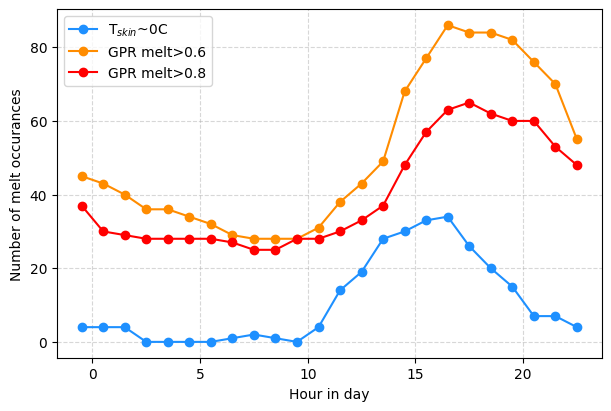

In [111]:
labels = {'skin melt':'T$_{skin}$~0C','gpr melt 0.6':'GPR melt>0.6','gpr melt 0.8':'GPR melt>0.8'}
fig, ax = plt.subplots(1, figsize=(6,4), constrained_layout=True)
# for melt_type in ['both melt','skin melt','gpr melt 0.6','gpr melt 0.9']:

for melt_type, c in zip(['skin melt','gpr melt 0.6','gpr melt 0.8'],['dodgerblue','darkorange','red']):
    
    plt.plot(hours[:-1]-.5, all_num_occurance[melt_type], label=labels[melt_type], marker='o', c=c)

plt.legend(loc='best')
plt.ylabel('Number of melt occurances')
plt.xlabel('Hour in day')
plt.grid(alpha=.5, ls='--')
# plt.savefig(plrams_fpath+'GPR-Tskin_diurnal-melt-occurances.png', dpi=300)

plt.show()

In [151]:

minutes = np.unique(simba_minutes)

all_num_occurance_mins = {'both melt':[],'neither melt':[],'skin melt':[],'gpr melt 0.6':[], 'gpr melt 0.8':[], 'skin melt lo':[]}

for melt_type in melt_idxs:
    print(melt_type)
    m_idx = melt_idxs[melt_type]
    
    # temp_midx = np.ma.copy(temps_rel_to_sfc)[m_idx[0],:]
    min_midx = np.ma.copy(simba_minutes)[m_idx[0]]

    for i, minval in enumerate(minutes):

        min_idx = np.where(min_midx==minval)[0]
        all_num_occurance_mins[melt_type].append(len(min_idx))

neither melt
both melt
skin melt
gpr melt 0.6
gpr melt 0.8
skin melt lo


In [98]:
avg_diurnal_swd = np.array([sleigh_interped['down_short_hemisp'][np.where(simba_minutes==m)].mean() for m in minutes])
avg_diurnal_ts = np.array([sleigh_interped['skin_temp'][np.where(simba_minutes==m)].mean() for m in minutes])

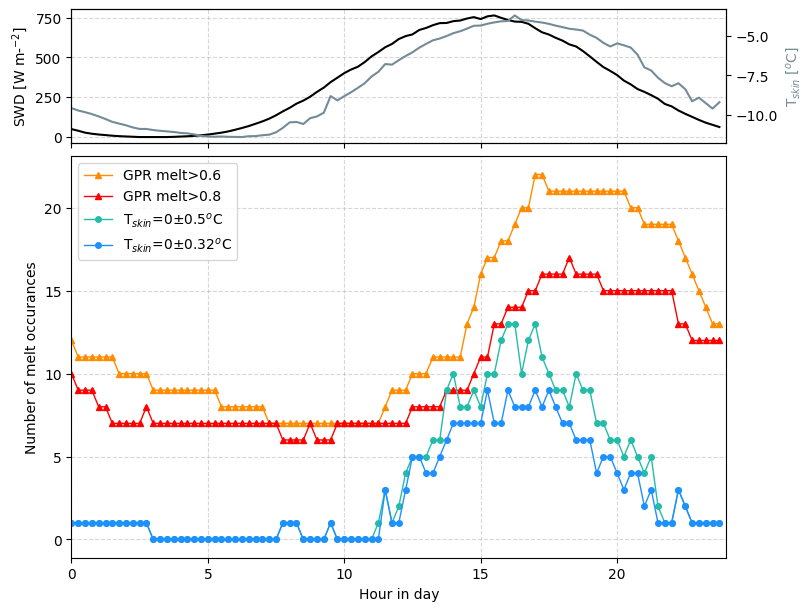

In [187]:
labels = {'skin melt':'T$_{skin}$=0$\pm$0.32$^o$C','gpr melt 0.6':'GPR melt>0.6','gpr melt 0.8':'GPR melt>0.8', 
          'skin melt lo':'T$_{skin}$=0$\pm$0.5$^o$C'}

fig, axs = plt.subplots(2, figsize=(8,6), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,3]))

axs[0].plot(minutes/60., avg_diurnal_swd, c='k')
ax0_twin = axs[0].twinx()
ax0_twin.plot(minutes/60., avg_diurnal_ts-273.15, c='xkcd:bluish grey')
ax0_twin.set_ylabel('T$_{skin}$ [$^o$C]', color='xkcd:bluish grey')

melts = ['gpr melt 0.6','gpr melt 0.8','skin melt lo','skin melt']
melt_colors = ['darkorange','red','xkcd:tealish','dodgerblue']

for melt_type, c in zip(melts, melt_colors):
    if 'gpr' in melt_type:
        marker = '^'
    elif 'skin' in melt_type:
        marker='o'
    
    axs[1].plot(minutes/60., all_num_occurance_mins[melt_type], label=labels[melt_type],  
                c=c, marker=marker, ms=4, lw=1)

axs[1].legend(loc='best')
axs[0].set_ylabel('SWD [W m-$^{-2}$]')
axs[1].set_ylabel('Number of melt occurances')

axs[1].set_xlabel('Hour in day')
axs[0].set_xlim(0,24)
for ax in axs.ravel():
    ax.grid(alpha=.5, ls='--')
# plt.savefig(plrams_fpath+'GPR-Tskin_diurnal-melt-occurances.png', dpi=300)

plt.show()

#### Suspect that times when GPR detects liquid but Tskin is below 0 are when the surface is cooling but subsurface is still warm

In [119]:
simba_temps = season_data_solar['temperature']

In [128]:
## make it relative to the surface
depths_rel_to_sfc = np.repeat(season_data_solar['height'].copy()[np.newaxis,:], season_data_solar['temperature'].shape[0], axis=0)

sfc_2d = np.ma.repeat(simba_sfc[:,np.newaxis], season_data_solar['temperature'].shape[1], axis=1)
depths_rel_to_sfc = depths_rel_to_sfc-sfc_2d

temporary_temp = np.ma.masked_where(depths_rel_to_sfc>0, season_data_solar['temperature'])# temporary temperature

temps_rel_to_sfc = []

m = 100 # size of 

for i in range(temporary_temp.shape[0]):
    temp_i = temporary_temp[i,:-1]
    sub_t = temp_i[~temp_i.mask]

    sub_t_filled = np.ma.concatenate( (sub_t, np.full(int(m-sub_t.count()), -999 )) )
    temps_rel_to_sfc.append(sub_t_filled)
    
temps_rel_to_sfc = np.ma.masked_equal(temps_rel_to_sfc, -999)


sub_depths = np.arange(0,temps_rel_to_sfc.shape[1])
sub_depths *= -2

In [141]:
# plot average profiles of SIMBA temperatures when GPR and Tskin disagree, with Tskin timeseries overlayed
disagree_idx = np.where((gpr_melt_interped>0.8)&((simba_skin-273.15)<-0.5))

disagree_simba_temp = temps_rel_to_sfc[disagree_idx[0],:]
disagree_simba_minutes = simba_minutes[disagree_idx]

avg_disagree_simba_temp = []

for i, (hr_min, hr_max) in enumerate(zip(minutes[:-1],minutes[1:])):

    min_idx = np.where((disagree_simba_minutes>=hr_min)&(disagree_simba_minutes<hr_max))[0]
    avg_disagree_simba_temp.append(disagree_simba_temp[min_idx,:].mean(axis=0))

avg_disagree_simba_temp = np.array(avg_disagree_simba_temp)


In [142]:
max_disagree_simba_temp = []

for i, (hr_min, hr_max) in enumerate(zip(minutes[:-1],minutes[1:])):

    min_idx = np.where((disagree_simba_minutes>=hr_min)&(disagree_simba_minutes<hr_max))[0]
    max_disagree_simba_temp.append(disagree_simba_temp[min_idx,:].max(axis=0))

max_disagree_simba_temp = np.array(max_disagree_simba_temp)

In [136]:
disagree_skin_temp = sleigh_interped['skin_temp'][disagree_idx[0]]

avg_disagree_skin_temp = []

for i, (hr_min, hr_max) in enumerate(zip(minutes[:-1],minutes[1:])):

    min_idx = np.where((disagree_simba_minutes>=hr_min)&(disagree_simba_minutes<hr_max))[0]
    avg_disagree_skin_temp.append(disagree_skin_temp[min_idx].mean(axis=0))

avg_disagree_skin_temp = np.array(avg_disagree_skin_temp)

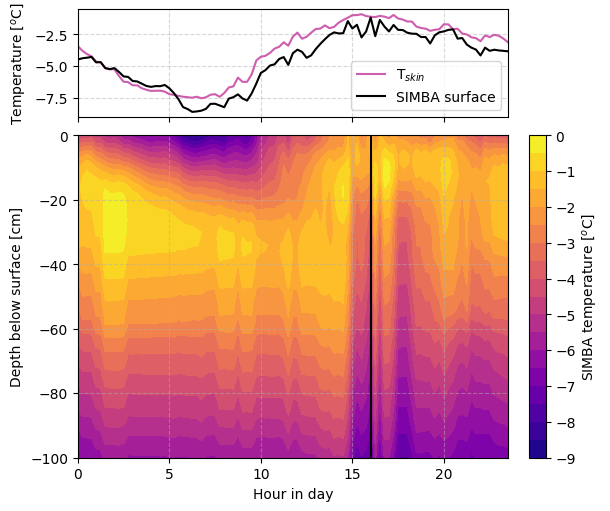

In [149]:
fig, axs = plt.subplots(2, figsize=(6,5), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,3]))

axs[0].plot(minutes[:-1]/60., avg_disagree_skin_temp-273.15, label='T$_{skin}$', c='xkcd:purplish pink')
axs[0].plot(minutes[:-1]/60., avg_disagree_simba_temp[:,0], label='SIMBA surface', c='k')
axs[0].legend(loc='best')
axs[0].set_ylabel('Temperature [$^o$C]')

cb = axs[1].contourf(minutes[:-1]/60., sub_depths, np.swapaxes(avg_disagree_simba_temp,0,1), 
             levels=np.arange(-9,0.01,.5), cmap=plt.cm.plasma)
plt.colorbar(cb, label='SIMBA temperature [$^o$C]', ax=axs[1])
axs[1].set_ylim(-100,0)
axs[1].set_ylabel('Depth below surface [cm]')
axs[1].set_xlabel('Hour in day')
axs[1].axvline(x=16, c='k')

for ax in axs.ravel():
    ax.grid(alpha=.5, ls='--')
plt.show()

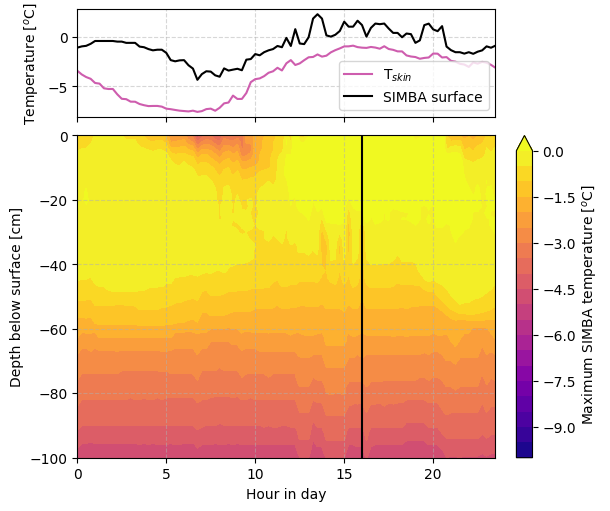

In [146]:
fig, axs = plt.subplots(2, figsize=(6,5), constrained_layout=True, sharex=True, gridspec_kw=dict(height_ratios=[1,3]))

axs[0].plot(minutes[:-1]/60., avg_disagree_skin_temp-273.15, label='T$_{skin}$', c='xkcd:purplish pink')
axs[0].plot(minutes[:-1]/60., max_disagree_simba_temp[:,0], label='SIMBA surface', c='k')
axs[0].legend(loc='best')
axs[0].set_ylabel('Temperature [$^o$C]')

cb = axs[1].contourf(minutes[:-1]/60., sub_depths, np.swapaxes(max_disagree_simba_temp,0,1), 
             levels=np.arange(-10,0.01,.5), cmap=plt.cm.plasma, extend='max')
plt.colorbar(cb, label='Maximum SIMBA temperature [$^o$C]', ax=axs[1])
axs[1].set_ylim(-100,0)
axs[1].set_ylabel('Depth below surface [cm]')
axs[1].set_xlabel('Hour in day')
axs[1].axvline(x=16, c='k')

for ax in axs.ravel():
    ax.grid(alpha=.5, ls='--')
plt.show()

Is there some way/some variable to show temperatures below the surface when they disagree? histograms to show if there is still temps near 0?

Stacked (or just multiple) histograms by hour(s) for disagreement after peak in Tskin melt ID? limit to above -60cm?

boxplots of # of points >-1C for each time step? 

In [181]:
disagree_simba_num_above_melt = []

for i, mmin in enumerate(minutes):

    min_idx = np.where(disagree_simba_minutes==mmin)[0]

    mmin_melty = []
    for m_idx in min_idx:
        masked_cold = np.ma.masked_less(disagree_simba_temp[m_idx,:], -2)
        mmin_melty.append( masked_cold.count() )
    disagree_simba_num_above_melt.append(mmin_melty)
print(len(disagree_simba_num_above_melt))

96


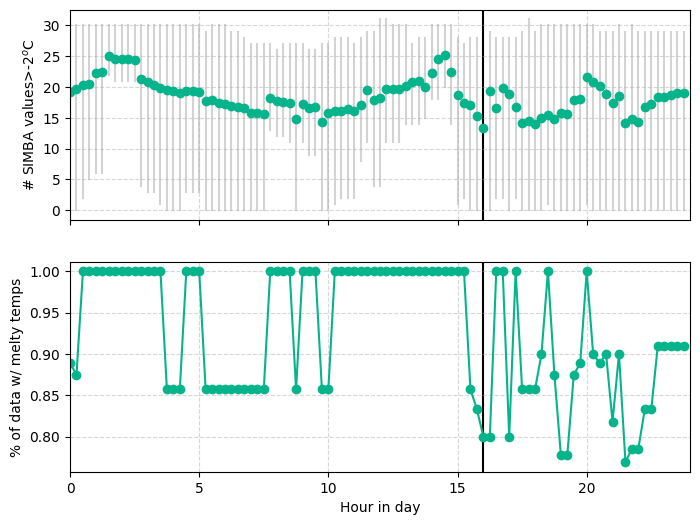

In [186]:
fig, axs = plt.subplots(2, sharex=True, figsize=(8,6))

percent_above_0 = []
for melty_data, hr in zip(disagree_simba_num_above_melt, minutes/60.):
    above_0 = len(np.where( np.array(melty_data)!=0)[0])
    percent_above_0.append(above_0/len(melty_data))
    
    axs[0].plot([hr, hr], [min(melty_data),max(melty_data)], c='lightgrey', zorder=0)
    axs[0].scatter(hr, np.mean(melty_data), c='xkcd:green blue', zorder=2)
axs[0].set_ylabel('# SIMBA values>-2$^o$C')

axs[1].plot(minutes/60., percent_above_0, marker='o', c='xkcd:green blue')
axs[1].set_ylabel('% of data w/ melty temps')
axs[1].set_xlabel('Hour in day')
axs[1].set_xlim(0,24)

for ax in axs.ravel():
    ax.grid(alpha=.5, ls='--')
    ax.axvline(x=16, c='k', zorder=0)

plt.show()

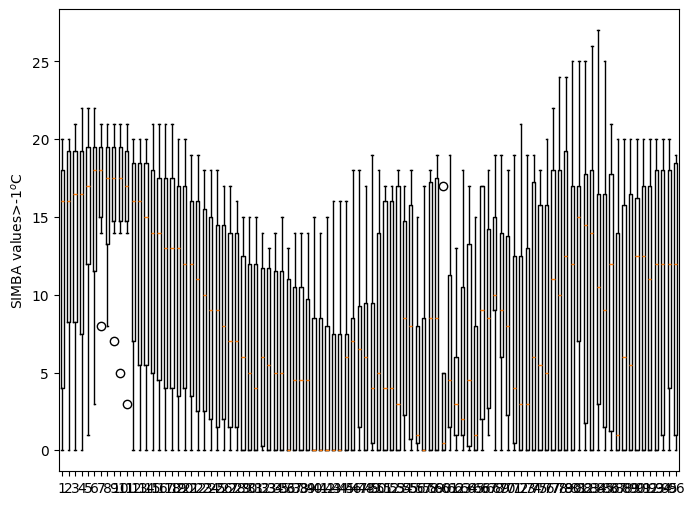

In [166]:
# fruit_weights = [
#     np.random.normal(130, 10, size=100),
#     np.random.normal(125, 20, size=100),
#     np.random.normal(120, 30, size=100),
# ]
# labels = ['peaches', 'oranges', 'tomatoes']
# colors = ['peachpuff', 'orange', 'tomato']

fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('SIMBA values>-1$^o$C')

bplot = ax.boxplot(disagree_simba_num_above_melt,)
                   # patch_artist=True)  # fill with color
                   # tick_labels=minutes)  # will be used to label x-ticks

# # fill with colors
# for patch in bplot['boxes']:
#     patch.set_facecolor('xkcd:green blue')
plt.show()